# Social Media Hybrid Recommender




1 — Imports & setup

In [1]:

import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


2 — Synthetic dataset generator (posts + users + ratings)

In [2]:

def generate_synthetic_social_data(n_users=300, n_posts=800):
    platforms = ['YouTube','Instagram','X','Snapchat','Facebook']
    topics = ['tech','travel','food','sports','fashion','music','education']
    posts = []
    for pid in range(n_posts):
        plat = random.choice(platforms)
        topic = random.choice(topics)
        title = f"{plat} {topic} post {pid}"
        hashtags = " ".join([f"#{topic}", f"#{plat.lower()}"])
        caption = f"{title} {hashtags}"
        posts.append({'post_id': pid, 'platform': plat, 'topic': topic, 'title': title, 'text': caption})
    posts_df = pd.DataFrame(posts)

    # users and ratings: sparse interactions
    interactions = []
    for uid in range(n_users):
        # each user interacts with 30-80 posts
        k = random.randint(30, 80)
        liked_posts = np.random.choice(n_posts, size=k, replace=False)
        # rating distribution biased by topic preference
        pref_topic = random.choice(topics)
        for pid in liked_posts:
            base = 3.0 + np.random.randn()*0.7  # base rating around 3
            if posts_df.loc[pid, 'topic'] == pref_topic:
                base += abs(np.random.randn()) * 1.2
            rating = min(5.0, max(1.0, round(base, 1)))
            interactions.append({'user_id': uid, 'post_id': pid, 'rating': rating})
    ratings_df = pd.DataFrame(interactions)
    return posts_df, ratings_df

posts_df, ratings_df = generate_synthetic_social_data()
print("posts:", posts_df.shape, "ratings:", ratings_df.shape)


posts: (800, 5) ratings: (16552, 3)


3 — Build user-item rating matrix (sparse)

In [3]:

def build_rating_matrix(ratings, n_users=None, n_items=None):
    if n_users is None:
        n_users = ratings['user_id'].max()+1
    if n_items is None:
        n_items = ratings['post_id'].max()+1
    rows = ratings['user_id'].values
    cols = ratings['post_id'].values
    data = ratings['rating'].values
    mat = csr_matrix((data, (rows, cols)), shape=(n_users, n_items))
    return mat

R = build_rating_matrix(ratings_df)
print("Rating matrix shape:", R.shape)


Rating matrix shape: (300, 800)


 4 — Collaborative Filtering via TruncatedSVD (matrix factorization approximation)

In [4]:

def train_svd_cf(R_csr, n_components=50):
    # Convert to dense-ish representation for SVD input: fill zeros with user mean to reduce sparsity bias
    R_dense = R_csr.toarray()
    user_means = np.where(R_dense.sum(axis=1)!=0, R_dense.sum(axis=1)/(R_dense!=0).sum(axis=1), 0)
    R_centered = R_dense - user_means.reshape(-1,1)
    svd = TruncatedSVD(n_components=n_components, random_state=SEED)
    user_factors = svd.fit_transform(R_centered)    # U * Sigma
    item_factors = svd.components_.T                 # V
    return svd, user_factors, item_factors, user_means

svd_model, U_factors, V_factors, user_means = train_svd_cf(R, n_components=50)
print("User factors:", U_factors.shape, "Item factors:", V_factors.shape)


User factors: (300, 50) Item factors: (800, 50)


5 — CF predict function

In [5]:

def cf_predict_scores(user_id, U, V, user_means):
    preds = U[user_id].dot(V.T) + user_means[user_id]
    return preds  # array of length n_items


6 — Content-based item embeddings (TF-IDF + one-hot metadata)

In [8]:
# Cell 6 — Content-based item embeddings (TF-IDF + one-hot metadata) [FIXED for sklearn >=1.4]
def build_item_content_embeddings(posts_df, tfidf_max_features=2000):
    # textual TF-IDF on "text" column
    tfidf = TfidfVectorizer(max_features=tfidf_max_features, stop_words='english')
    tfidf_mat = tfidf.fit_transform(posts_df['text'].fillna(''))

    # one-hot encode platform & topic
    try:
        ohe = OneHotEncoder(sparse_output=False)  # ✅ for new sklearn versions
    except TypeError:
        ohe = OneHotEncoder(sparse=False)         # fallback for older sklearn

    meta = ohe.fit_transform(posts_df[['platform', 'topic']])

    # combine and normalize
    from scipy.sparse import hstack
    combined = hstack([tfidf_mat, csr_matrix(meta)])
    combined = normalize(combined, norm='l2', axis=1)
    return combined, tfidf, ohe

item_embeddings, tfidf_vec, meta_ohe = build_item_content_embeddings(posts_df)
print("Item embeddings shape:", item_embeddings.shape)


Item embeddings shape: (800, 814)


 7 — Build user content profile (average of items user liked with rating >= threshold)

In [9]:

def user_profile_from_history(user_id, ratings_df, item_embeddings, rating_threshold=4.0):
    liked = ratings_df[(ratings_df['user_id']==user_id) & (ratings_df['rating']>=rating_threshold)]['post_id'].values
    if len(liked)==0:
        # fallback: average all items
        profile = np.array(item_embeddings.mean(axis=0)).ravel()
    else:
        profile = np.array(item_embeddings[liked].mean(axis=0)).ravel()
    return profile

# Quick check
profile = user_profile_from_history(0, ratings_df, item_embeddings)
print("Profile length:", profile.shape)


Profile length: (814,)


 8 — Recommendation function (CF + CBF hybrid)

In [10]:
# Cell 8 — Recommendation function (CF + CBF hybrid)
def get_hybrid_recommendations(user_id, top_k=10, alpha=0.6):
    # CF scores
    cf_scores = cf_predict_scores(user_id, U_factors, V_factors, user_means)
    # CBF scores: cosine similarity between user profile and all item embeddings
    profile = user_profile_from_history(user_id, ratings_df, item_embeddings)
    cbf_scores = cosine_similarity(profile.reshape(1,-1), item_embeddings).ravel()
    # normalize both
    cf_norm = (cf_scores - cf_scores.min()) / (cf_scores.max() - cf_scores.min() + 1e-8)
    cbf_norm = (cbf_scores - cbf_scores.min()) / (cbf_scores.max() - cbf_scores.min() + 1e-8)
    hybrid = alpha * cf_norm + (1-alpha) * cbf_norm
    # filter out already rated items
    seen = set(ratings_df[ratings_df['user_id']==user_id]['post_id'].tolist())
    candidates = [(i, hybrid[i]) for i in range(len(hybrid)) if i not in seen]
    candidates = sorted(candidates, key=lambda x: x[1], reverse=True)[:top_k]
    recs = pd.DataFrame([{'post_id': pid, 'score': score} for pid, score in candidates])
    recs = recs.merge(posts_df, on='post_id', how='left')
    return recs

# Example
print(get_hybrid_recommendations(user_id=5, top_k=8, alpha=0.6))


   post_id     score  platform   topic                     title  \
0      426  0.753248         X  travel         X travel post 426   
1      391  0.724388   YouTube    food     YouTube food post 391   
2      304  0.723625  Facebook  travel  Facebook travel post 304   
3      529  0.722759   YouTube  travel   YouTube travel post 529   
4      334  0.721518   YouTube  travel   YouTube travel post 334   
5      179  0.716249         X  travel         X travel post 179   
6       47  0.711320  Facebook  travel   Facebook travel post 47   
7        1  0.710437         X  travel           X travel post 1   

                                         text  
0                X travel post 426 #travel #x  
1        YouTube food post 391 #food #youtube  
2  Facebook travel post 304 #travel #facebook  
3    YouTube travel post 529 #travel #youtube  
4    YouTube travel post 334 #travel #youtube  
5                X travel post 179 #travel #x  
6   Facebook travel post 47 #travel #facebook  
7  

9 — Simple visualizations: ratings distribution & top-10 recommended platforms

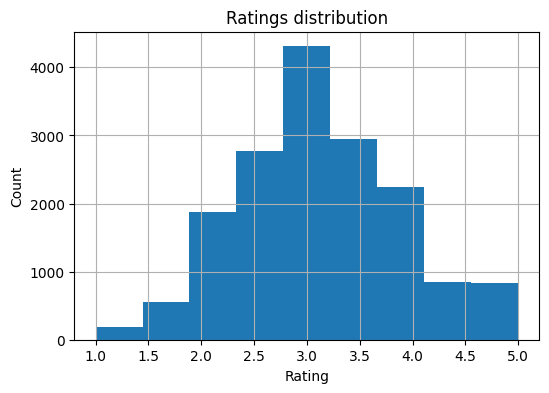

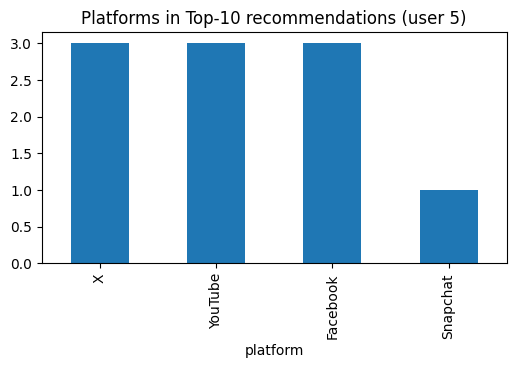

In [11]:

def plot_ratings_distribution(ratings_df):
    plt.figure(figsize=(6,4))
    ratings_df['rating'].hist(bins=9)
    plt.title("Ratings distribution")
    plt.xlabel("Rating"); plt.ylabel("Count")
    plt.show()

plot_ratings_distribution(ratings_df)

# visualize top platforms in recommendations for a sample user
recs = get_hybrid_recommendations(5, top_k=10)
plt.figure(figsize=(6,3))
recs['platform'].value_counts().plot(kind='bar')
plt.title("Platforms in Top-10 recommendations (user 5)")
plt.show()
